In [2]:
!pip install keras-core --upgrade
!pip install -q keras-nlp
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 4.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras-core
    Found existing installation: keras-core 0.1.5
    Uninstalling keras-core-0.1.5:
      Successfully uninstalled keras-core-0.1.5


In [43]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt


print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.12.0
Keras version: 0.1.7
KerasNLP version: 0.6.1


# Load the Detect AI Generated Text
Let's have a look at all the data files

In [4]:
DATA_DIR = '/kaggle/input/llm-detect-ai-generated-text/'

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


# Explore the dataset

Let's look at the distribution of labels in the training set.

In [5]:
train_prompts = pd.read_csv(DATA_DIR + "train_prompts.csv")
print(train_prompts.info())
train_prompts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prompt_id     2 non-null      int64 
 1   prompt_name   2 non-null      object
 2   instructions  2 non-null      object
 3   source_text   2 non-null      object
dtypes: int64(1), object(3)
memory usage: 192.0+ bytes
None


,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


The two prompts used here are 'Car-free cities' and 'Does electoral college work?'

In [6]:
train_essays = pd.read_csv(DATA_DIR + "train_essays.csv")
print(train_essays.info())
train_essays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


Text(0.5, 1.0, 'Distribution of prompt ID')

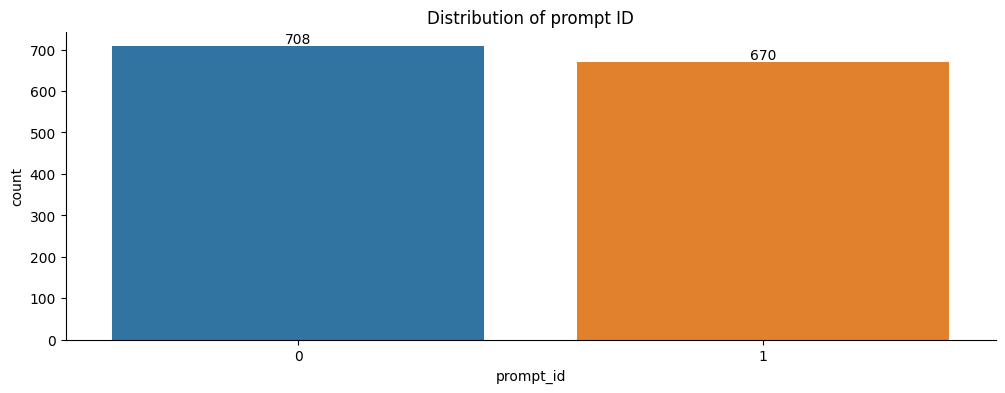

In [7]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=train_essays,
                   x="prompt_id")

abs_values = train_essays['prompt_id'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of prompt ID")

The prompts are distributed quite equally

Text(0.5, 1.0, 'Distribution of Generated Text')

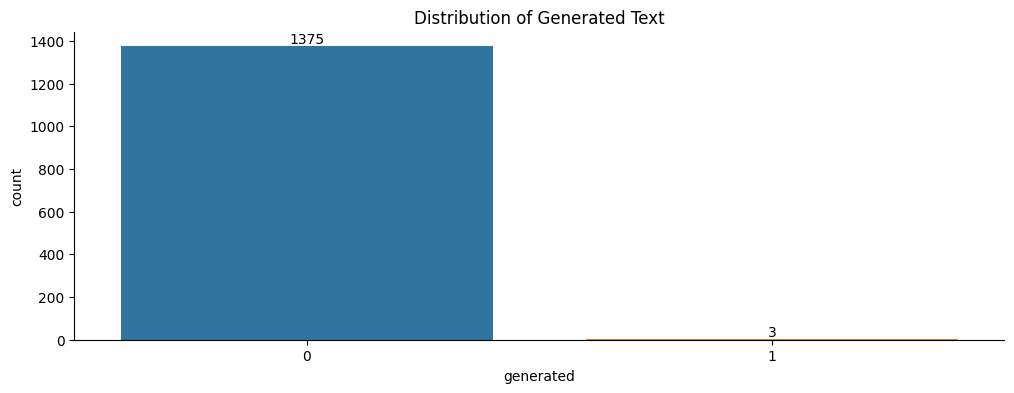

In [8]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=train_essays,
                   x="generated")

abs_values = train_essays['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

1375 essays are written by human and only 3 by AI.

We need other LLM generated dataset to balance this out


In [9]:
test_essays = pd.read_csv(DATA_DIR + "test_essays.csv")
print(test_essays.info())
test_essays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3 non-null      object
 1   prompt_id  3 non-null      int64 
 2   text       3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes
None


,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [10]:
test_essays["text"].apply(lambda x : len(x))

0    12
1    12
2    12
Name: text, dtype: int64

The test dataset contains only 3 essays. The length of each essay is very small (12 characters).

# Add new data to the training dataset

 We will use the dataset created by [DAREK KŁECZEK](https://www.kaggle.com/competitions/llm-detect-ai-generated-text/discussion/455517) to add data generated by other LLMs

In [11]:
train_essays_ext = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv')

train_essays_ext.rename(columns = {"label":"generated"}, inplace=True)

train_essays_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44206 entries, 0 to 44205
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   44206 non-null  object
 1   text       44206 non-null  object
 2   generated  44206 non-null  int64 
 3   source     44206 non-null  object
 4   prompt     12911 non-null  object
 5   fold       44206 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [12]:
train_essays_ext.head()

,essay_id,text,generated,source,prompt,fold
0,E897534557AF,"In recent years, technology has had a profoun...",1,mistral7binstruct_v2,\nTask: Write an essay discussing the positive...,1
1,DFBA34FFE11D,Should students participate in an extracurricu...,0,persuade_corpus,NaN,2
2,af37ecf5,The electoral college is a symbol of mockery a...,0,train_essays,NaN,5
3,5EC2696BAD78,This is why I think the principle should allow...,0,persuade_corpus,NaN,8
4,llama_70b_v1843,I strongly believe that meditation and mindful...,1,llama_70b_v1,Some schools have implemented meditation and m...,0


Text(0.5, 1.0, 'Distribution of Generated Text')

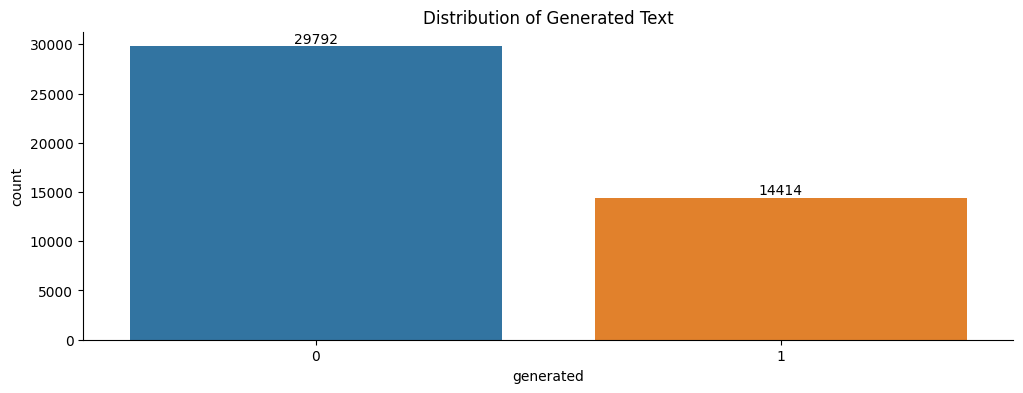

In [13]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=train_essays_ext,
                   x="generated")

abs_values = train_essays_ext['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [14]:
train_essays


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [15]:
train_essays_final = pd.concat([train_essays_ext[["text", "generated"]], train_essays[["text", "generated"]]])

train_essays_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45584 entries, 0 to 1377
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       45584 non-null  object
 1   generated  45584 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [16]:
train_essays_final.head()

,text,generated
0,"In recent years, technology has had a profoun...",1
1,Should students participate in an extracurricu...,0
2,The electoral college is a symbol of mockery a...,0
3,This is why I think the principle should allow...,0
4,I strongly believe that meditation and mindful...,1


# Prepare data

Let's count the number of words in each essay

In [17]:
train_essays_final["text_length"] = train_essays_final["text"].apply(lambda x : len(x.split()))

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Distribution of the length per essay - Train dataset')

<Figure size 4000x5000 with 0 Axes>

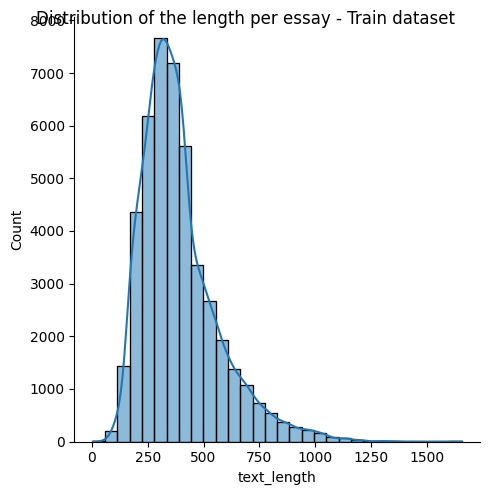

In [18]:
fig = plt.figure(figsize=(40,50))
plot = sns.displot(data=train_essays_final,
                 x="text_length", bins=30, kde=True)
plot.fig.suptitle("Distribution of the length per essay - Train dataset")


In [19]:
train_essays_final["text_length"].mean() 

391.61038961038963

In [20]:
train_essays_final["text_length"].std()

173.10769358493664

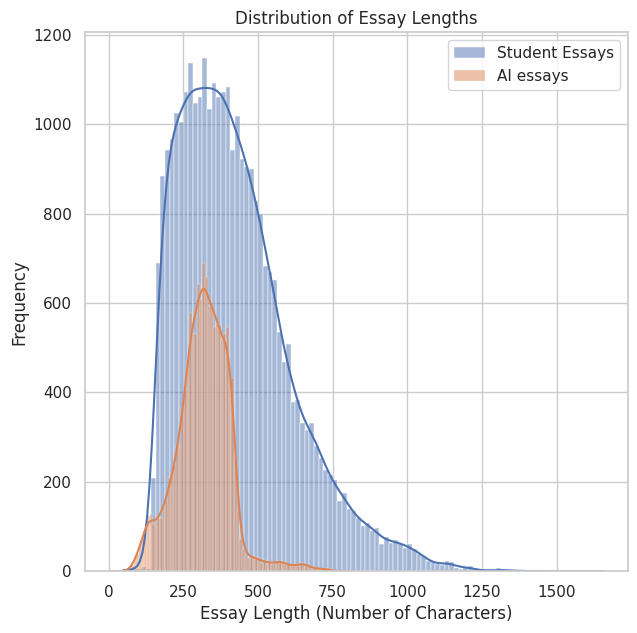

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(7, 7))

#Student Essays
sns.histplot(data=train_essays_final[train_essays_final["generated"] == 0]["text_length"], label = "Student Essays", kde = True)
#AI generated Essays
sns.histplot(data=train_essays_final[train_essays_final["generated"] == 1]["text_length"], label = "AI essays", kde = True)

plt.title('Distribution of Essay Lengths')
plt.xlabel('Essay Length (Number of Characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

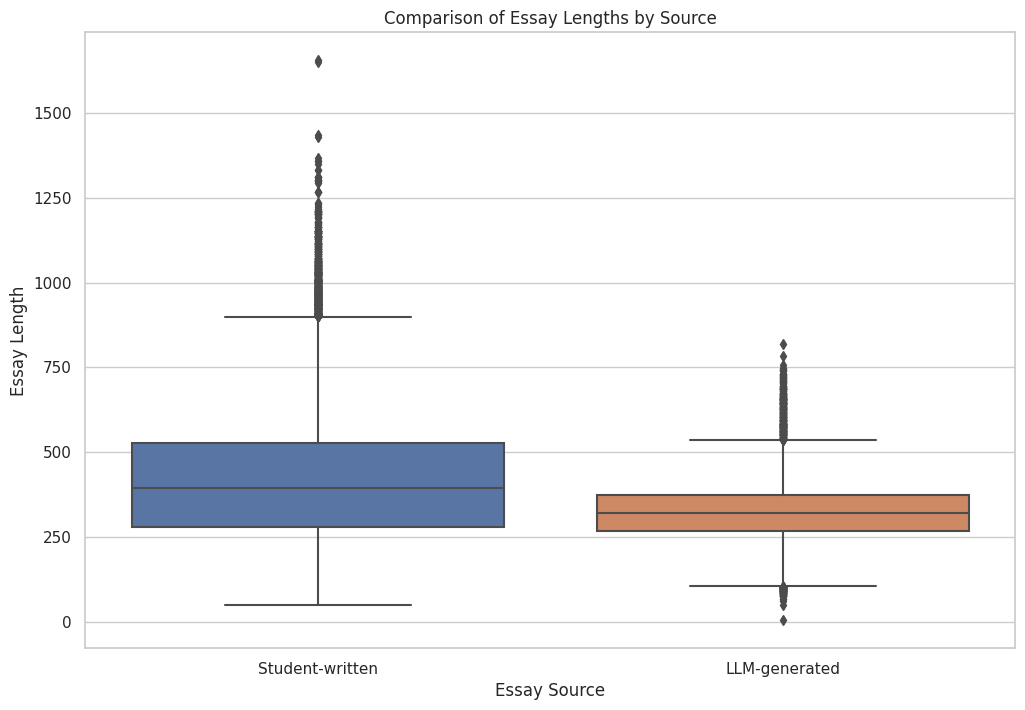

In [22]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='generated', y='text_length', data=train_essays_final)
plt.title('Comparison of Essay Lengths by Source')
plt.xlabel('Essay Source')
plt.ylabel('Essay Length')
plt.xticks([0, 1], ['Student-written', 'LLM-generated'])
plt.show()

To note that the length of LLM generated essays are smaller in comparison to Student-written ones

There might be other factors like word count, number of unique words used, and sentence counts etc, that might prove to be a distinguishing factor. Hence we are going to add these metrics as features into our dataset

In [23]:
def create_text_metrics(text):
    word_count = len(text.split())
    sentence_count = len(text.split('.'))
    unique_word_count = len(set(text.split()))
    return word_count, sentence_count, unique_word_count

train_essays_final['metrics'] = train_essays_final['text'].apply( create_text_metrics)
train_essays_final[['word_count', 'sentence_count', 'unique_word_count']] = pd.DataFrame(train_essays_final['metrics'].tolist(), index = train_essays_final.index)
train_essays_final.drop('metrics', axis=1, inplace=True)

comparison_metrics = train_essays_final.groupby('generated')[['word_count',  'sentence_count', 'unique_word_count']].mean()
comparison_metrics

,word_count,sentence_count,unique_word_count
generated,,,
0,425.575031,21.826259,201.192479
1,318.184851,17.380870,166.604287


The number of unique words used by students seem to be larger.

How related are the student vs AI essays to their respective prompts? //do later

In [28]:
train_essays_final

,text,generated,text_length,word_count,sentence_count,unique_word_count
0,"In recent years, technology has had a profoun...",1,254,254,14,160
1,Should students participate in an extracurricu...,0,640,640,31,292
2,The electoral college is a symbol of mockery a...,0,542,542,30,276
3,This is why I think the principle should allow...,0,212,212,8,100
4,I strongly believe that meditation and mindful...,1,332,332,18,148
...,...,...,...,...,...,...
1373,There has been a fuss about the Elector Colleg...,0,430,430,27,225
1374,Limiting car usage has many advantages. Such a...,0,397,397,18,187
1375,There's a new trend that has been developing f...,0,749,749,37,409
1376,As we all know cars are a big part of our soci...,0,525,525,32,289


# Create the model

In [44]:

SEQ_LENGTH = 512

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_en_uncased",
    sequence_length=SEQ_LENGTH,
)

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    "distil_bert_base_en_uncased",
    num_classes=2,
    activation=None,
    preprocessor=preprocessor,
)

# Re-compile (e.g., with a new learning rate)
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(5e-4),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy()
   ]
)


# Access backbone programmatically (e.g., to change `trainable`).
classifier.backbone.trainable = False


classifier.summary()

Preprocessor: "distil_bert_preprocessor_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer_5 (DistilBertTokenizer)      │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ distil_bert_backbone_5        │ (None, None, 768)         │  66,362,880 │ padding_mask[0][0],            │
│ (DistilBertBackbone)          │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item_5 (GetItem)          │ (None, 768)               │           0 │ distil_bert_backbone_5[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │     590,592 │ get_item_5[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │           0 │ pooled_dense[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │       1,538 │ classifier_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 592,130 (2.26 MB)

 Non-trainable params: 66,362,880 (253.15 MB)

In [46]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_essays_final["text"],
                                                    train_essays_final["generated"],
                                                    test_size=0.33,
                                                    random_state=42)

In [48]:
# Fit
classifier.fit(x=X_train, 
               y=y_train,
               validation_data=(X_test, y_test),
               epochs=1,
               batch_size=64
              )

478/478 ━━━━━━━━━━━━━━━━━━━━ 749s 2s/step - loss: 0.0695 - sparse_categorical_accuracy: 0.9768 - val_loss: 0.2673 - val_sparse_categorical_accuracy: 0.9016


In [49]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Generated","Generated"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


In [50]:
classifier.save("models_distilbert.keras")

In [52]:
y_pred_test = classifier.predict(X_test)

471/471 ━━━━━━━━━━━━━━━━━━━━ 237s 504ms/step


In [64]:
y_pred_test

array([[-7.992242 ,  8.380634 ],
       [ 2.0305989, -1.6654336],
       [ 3.537425 , -3.2126048],
       ...,
       [ 3.1989977, -2.9255617],
       [ 1.5239639, -1.1392666],
       [-5.671939 ,  6.026447 ]], dtype=float32)

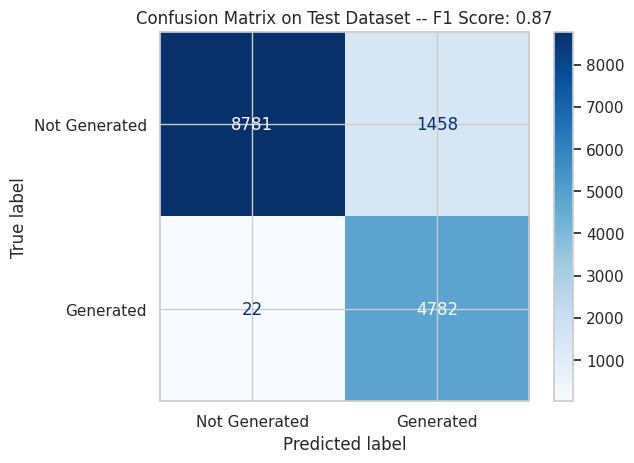

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
displayConfusionMatrix(y_test, y_pred_test,  "Test")

We finetuned DistilBert to detect AI or Human Generated Text and received a F1 Score between 0.85-0.90

Testing

In [84]:
train_essays_final.query('generated==0')['text'][0]

'Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.\n\nIn like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article

In [85]:
test = pd.Series(['Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.\n\nIn like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article, "Paris bans driving due to smog," by Robert Duffer says, how Paris, after days of nearrecord pollution, enforced a partial driving ban to clear the air of the global city. It also says, how on Monday, motorist with evennumbered license plates were ordered to leave their cars at home or be fined a 22euro fine 31. The same order would be applied to oddnumbered plates the following day. Cars are the reason for polluting entire cities like Paris. This shows how bad cars can be because, of all the pollution that they can cause to an entire city.\n\nLikewise, in the article, "Carfree day is spinning into a big hit in Bogota," by Andrew Selsky says, how programs that\'s set to spread to other countries, millions of Columbians hiked, biked, skated, or took the bus to work during a carfree day, leaving streets of this capital city eerily devoid of traffic jams. It was the third straight year cars have been banned with only buses and taxis permitted for the Day Without Cars in the capital city of 7 million. People like the idea of having carfree days because, it allows them to lesson the pollution that cars put out of their exhaust from people driving all the time. The article also tells how parks and sports centers have bustled throughout the city uneven, pitted sidewalks have been replaced by broad, smooth sidewalks rushhour restrictions have dramatically cut traffic and new restaurants and upscale shopping districts have cropped up. Having no cars has been good for the country of Columbia because, it has aloud them to repair things that have needed repairs for a long time, traffic jams have gone down, and restaurants and shopping districts have popped up, all due to the fact of having less cars around.\n\nIn conclusion, the use of less cars and having carfree days, have had a big impact on the environment of cities because, it is cutting down the air pollution that the cars have majorly polluted, it has aloud countries like Columbia to repair sidewalks, and cut down traffic jams. Limiting the use of cars would be a good thing for America. So we should limit the use of cars by maybe riding a bike, or maybe walking somewhere that isn\'t that far from you and doesn\'t need the use of a car to get you there. To me, limiting the use of cars might be a good thing to do.'])

In [86]:
y_new_pred = classifier.predict(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


In [87]:
np.argmax(y_new_pred, axis=1)

array([0])

0 means Human written